In [1]:
"""
Generalized predictive coding
"""

import matplotlib.pyplot as plt
import torch
import math
import numpy as np
import IPython
import MovingMNIST as MovingMNIST
from model_circles import *
from circles_dataset import *

In [2]:
"""
The true generative model in state space form
x' = Ax + Bv + w   # hidden state motion
y = Cx + z         # output
"""

# state transition weights x->x'
A = torch.tensor([[0.0484, 0.7535],
                  [-0.7617, -0.2187]]).float()

# input weights v->x'
B = torch.tensor([[0.3604],
                 [0.3604]]).float()

# output weights x->y
C = torch.tensor([[0.2265, -0.4786],
                  [0.4066, -0.2641],
                  [0.3871, 0.3817],
                  [-0.1630, -0.9290]]).float()

# hidden state x
x = torch.tensor([[0],[0]]).float()

# response y
y = torch.tensor([[0],[0],[0],[0]]).float()

# create sequence of causes v
def bump(t):
    return torch.exp(torch.tensor([-0.25*(t-12)**2])).unsqueeze(-1).float()

dt = .1 # sampling rate
true_cause = [bump(t*dt) for t in range(1,int(32/dt),1)]
v = true_cause[0]


/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


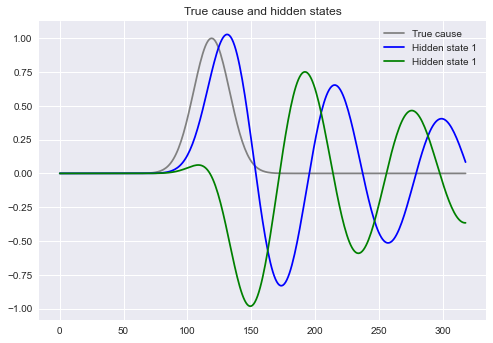

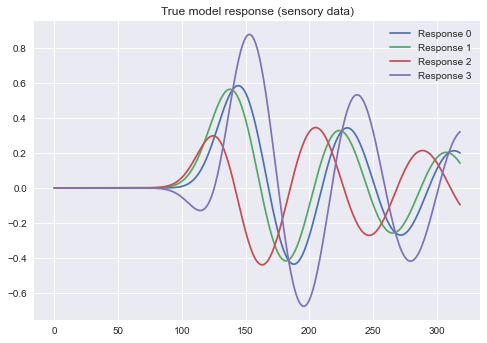

In [3]:
"""
Run the SSM to generate sensory data
# todo input and output matmul are slightly different to network (1D matmul)
"""
if True:
    xs = []; ys = []
    for t, v in enumerate(true_cause):
        xs.append(np.asarray(x.detach()));
        ys.append(np.asarray(y.detach()))
        y = torch.matmul(C,x)
        x = x + (torch.matmul(B,v) + torch.matmul(A,x))*dt

    # plot cause and hidden states
    plt.plot(true_cause, color="grey", label="True cause")
    plt.plot(np.asarray(xs)[:,0,0], color="blue", label="Hidden state 1")
    plt.plot(np.asarray(xs)[:,1,0], color="green", label="Hidden state 1")
    plt.legend(); plt.title("True cause and hidden states"); plt.show()

    # plot model response
    for r in range(4): plt.plot(np.asarray(ys)[:,r], label=f"Response {r}")
    plt.legend(); plt.title("True model response (sensory data)"); plt.show()

In [4]:
""" Predictive coding (generative model inversion, filtering)
Generalised predictive coding network with 4 output units, 2 hidden units, 1 cause unit
"""

def run_model(A, B, C, ys=None, true_cause=None,
              feed_cause=True, generate=True,
              plot=True, dt=0.1,
              inference_steps=1, epochs=1):
    """
    Generate or filter with a predictive coding model
    A:          prior transition weights (dynamical weights f(x)->x')
    B:          prior input weights (dynamical weights f(v)->x')
    C:          prior output weights (hierarchical weights g(x)->y)
    ys:         Sensory observations
    true_cause: Cause input to deepest hierarchical layer
    """

    for epoch in range(epochs):
        # logging
        if generate: res1, res2, res3 = [], [], []
        errors, cov_h, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3 = [[] for _ in range(8)]
        err_g1, err_g2, err_g3, cov_g1, cov_g2, cov_g3 = [[] for _ in range(6)]
        err_h1, err_h2, err_h3, l0, l1, l2, l3, l4, l5, l6 = [[] for _ in range(10)]

        # initialize states
        if generate:
            net.layers[1].dyn_model.layers[0].states.cause_state = true_cause[0] # cause
            for l in net.layers[1].dyn_model.layers[1:]: l.states.cause_state = l.states.cause_state.detach()*0 # cause coordinates
            net.layers[1].dyn_model.layers[0].states.hidd_state = torch.tensor(xs[0].T) # hidden
            for l in net.layers[1].dyn_model.layers[1:]: l.states.hidd_state = l.states.hidd_state.detach()*0 # hidden coordinates

        # initialize weights
        net.layers[1].net_h[0].weight = torch.nn.Parameter(C) #  hierarchical weights g(x)
        net.layers[1].dyn_model.nets_d[0].weight = torch.nn.Parameter(torch.cat([B.T,A]).T) # dynamical weights f(x)
        net.layers[1].dyn_model.nets_d[1].weight = torch.nn.Parameter(net.layers[1].dyn_model.nets_d[1].weight) # dynamical weights f(x)

        for t, (y, c) in enumerate(zip(ys, true_cause)):
            y = torch.tensor(y.T)

            if generate: # transition
                net.feed(None, c) # feed cause
                net.layers[1].dyn_model.forward_dynamical(apply=True) # predict hidden state motion x' = f(x)
                net.layers[1].dyn_model.apply_encoded_motion(hidden=True, cause=False, dt=dt) # apply hidden state motion x -> x+x'

            pred = net.layers[1].forward() # hierarchical prediction

            if not generate: # infer
                for _ in range(inference_steps):
                    e, _, _, ch, _ = net.iterative_inference(data=y, target=c if feed_cause else None) # step hierarchical
                    eg1, eh1, ed1, cg1, cd1 = net.layers[1].dyn_model.iterative_inference(predict_hierarchical=False) # step dynamical

                net.layers[0].dyn_model.iterative_inference(y, updates=2) # encode input in generalized coordinates
                net.layers[0].dyn_model.state_diff(step=True) # track sensory state motion

                # logging
                errors, cov_h = errors + e, cov_h + ch
                errors_d1, cov_d1 = errors_d1 + ed1, cov_d1 + cd1
                err_g1, cov_g1, err_h1 = err_g1 + eg1, cov_g1 + cg1, err_h1+eh1

            if generate: # collect model response
                res1.append(pred[0].T.detach().numpy().copy()) # observation
                res2.append(pred[1].T.detach().numpy().copy()) # observation coord 1
                res3.append(pred[2].T.detach().numpy().copy()) # observation coord 2

            if plot:
                l0.append(net.layers[-1].states.cause_state[0,0].detach().numpy().copy())
                l1.append(pred[0][0,0].numpy().copy())
                l2.append(pred[1][0,0].numpy().copy())
                l3.append(pred[2][0,0].numpy().copy())
                l4.append(net.layers[1].states.hidd_state[0,0].detach().numpy().copy())
                l5.append(net.layers[1].states.hidd_state[0,1].detach().numpy().copy())
                if not generate: l6.append(y[0,0].numpy().copy())

    if plot: # plot results
        plt.plot(l0, color="grey", label=f"Cause GC{1}")
        plt.plot(l1, color="green", label=f"Prediction 1 GC {1}")
        plt.plot(l2, color="green", label=f"Prediction 1 GC {2}", alpha=0.6)
        plt.plot(l3, color="green", label=f"Prediction 1 GC {3}", alpha=0.3)
        plt.plot(l4, color="blue", label="Hidden state 1")
        plt.plot(l5, color="blue", label="Hidden state 2")
        if not generate: plt.plot(l6, color="black", label="True observation")
        plt.ylim(-1.3, 1.3)
        plt.legend(); plt.show()

    if plot and not generate: # plot losses
        plot_graph(errors, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3,cov_g1,
           cov_g2, cov_g3, err_g1, err_g2, err_g3, err_h1, err_h2, err_h3, cov_h,
           hierarchical=True, g_coords=False, dynamical=True)

    if generate: return true_cause, res1, res2, res3

/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


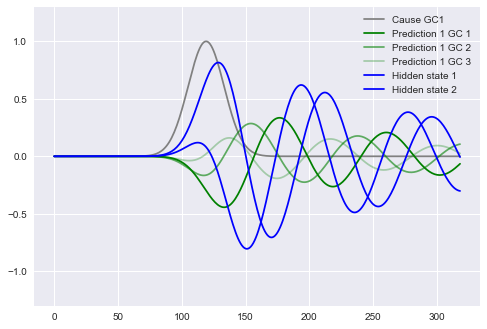

In [5]:
# generate true states and observations with the generative model
net = GPC_net(b_size=1, dynamical_net=False, cause_sizes=[4, 1], hidden_sizes=[0, 2], gen_coords=3)
true_cause, res1, res2, res3 = run_model(A,B,C,ys, true_cause, feed_cause=True, generate=True, plot=True)

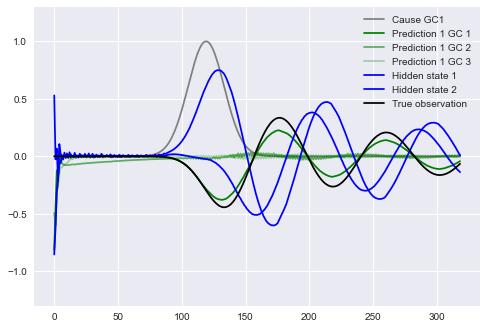

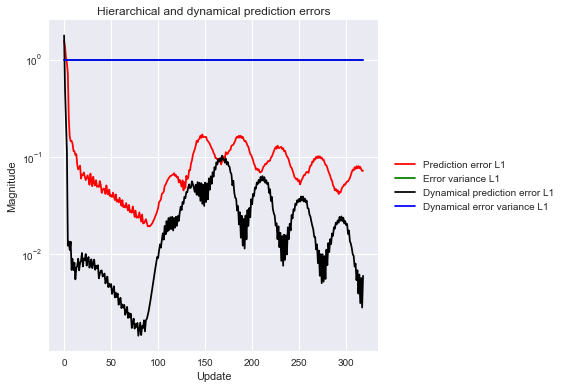

In [6]:
# predictive coding: filter observations by inverting the generative model
# we provide the true cause (input) to check if hidden states are correctly inferred
net = GPC_net(b_size=1, dynamical_net=False, cause_sizes=[4, 1], hidden_sizes=[0, 2], gen_coords=3)
run_model(A,B,C, res1, true_cause, feed_cause=True, generate=False, plot=True)

/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


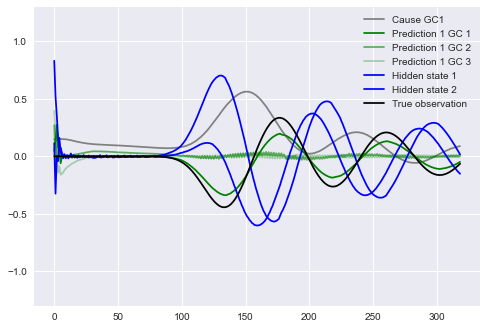

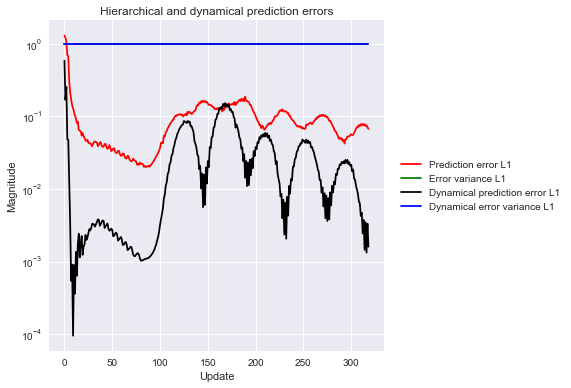

In [7]:
# predictive coding: filter observations by inverting the generative model
# this time we let the model infer the cause
net = GPC_net( b_size=1, dynamical_net=False, cause_sizes=[4, 1], hidden_sizes=[0, 2], gen_coords=3)
run_model(A,B,C, res1, true_cause, feed_cause=False, generate=False, plot=True)

/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


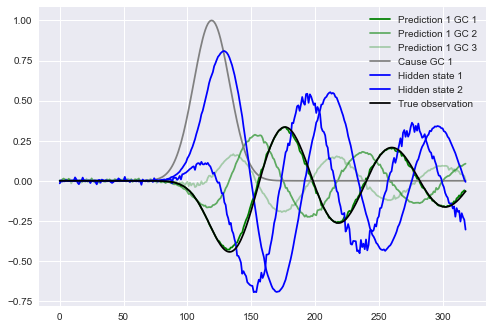

In [8]:
# Process the observation sequence in parallel instead of sequentially
net = GPC_net(b_size=len(res1), dynamical_net=False, cause_sizes=[4, 1], hidden_sizes=[0, 2], gen_coords=3)

# turn cause sequence into a batch
true_cause_seq = torch.stack(true_cause,0).reshape([319,1])

# turn sensory observations from sequences into batches
seq_batch1 = torch.from_numpy(np.asarray(res1)).reshape([319,4])
seq_batch2 = torch.from_numpy(np.asarray(res2)).reshape([319,4])
seq_batch3 = torch.from_numpy(np.asarray(res3)).reshape([319,4])

feed_cause = True; plot = False; generate = False;
inference_steps = 10; epochs = 1

c = true_cause_seq

for epoch in range(epochs):
    # logging
    errors, cov_h, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3 = [[] for _ in range(8)]
    err_g1, err_g2, err_g3, cov_g1, cov_g2, cov_g3 = [[] for _ in range(6)]
    err_h1, err_h2, err_h3, l0, l1, l2, l3, l4, l5, l6 = [[] for _ in range(10)]

    # initialize weights
    net.layers[1].net_h[0].weight = torch.nn.Parameter(C) #  hierarchical weights g(x)
    net.layers[1].dyn_model.nets_d[0].weight = torch.nn.Parameter(torch.cat([B.T,A]).T) # dynamical weights f(x)
    net.layers[1].dyn_model.nets_d[1].weight = torch.nn.Parameter(net.layers[1].dyn_model.nets_d[1].weight) # dynamical weights f(x)

    # prior prediction
    pred = net.layers[1].forward() # hierarchical prediction

    # infer
    for _ in range(inference_steps):
        # feed sensory observations in generalized coordinates
        net.layers[0].dyn_model.layers[0].states.cause_state = seq_batch1
        net.layers[0].dyn_model.layers[1].states.cause_state = seq_batch2
        net.layers[0].dyn_model.layers[2].states.cause_state = seq_batch3

        e, _, _, ch, _ = net.iterative_inference(data=None, target=c if feed_cause else None) # step hierarchical
        eg1, eh1, ed1, cg1, cd1 = net.layers[1].dyn_model.iterative_inference(predict_hierarchical=False) # step dynamical

    # posterior prediction
    pred = net.layers[1].forward() # hierarchical prediction

    # logging
    errors, cov_h = errors + e, cov_h + ch
    errors_d1, cov_d1 = errors_d1 + ed1, cov_d1 + cd1
    err_g1, cov_g1, err_h1 = err_g1 + eg1, cov_g1 + cg1, err_h1+eh1

if plot and not generate: # plot losses
    plot_graph(errors, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3,cov_g1,
       cov_g2, cov_g3, err_g1, err_g2, err_g3, err_h1, err_h2, err_h3, cov_h,
       hierarchical=True, g_coords=False, dynamical=True)

plt.plot(pred[0][:,0], color="green", label=f"Prediction 1 GC {1}")
plt.plot(pred[1][:,0], color="green", label=f"Prediction 1 GC {2}", alpha=0.6)
plt.plot(pred[2][:,0], color="green", label=f"Prediction 1 GC {3}", alpha=0.3)
plt.plot(net.layers[1].states.cause_state.detach().numpy().copy()[:,0], color="grey", label="Cause GC 1")
plt.plot(net.layers[1].states.hidd_state.detach().numpy().copy()[:,0], color="blue", label="Hidden state 1")
plt.plot(net.layers[1].states.hidd_state.detach().numpy().copy()[:,1], color="blue", label="Hidden state 2")
plt.plot(np.asarray(res1)[:,0,0], color="black", label="True observation")
plt.legend(); plt.show()

/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


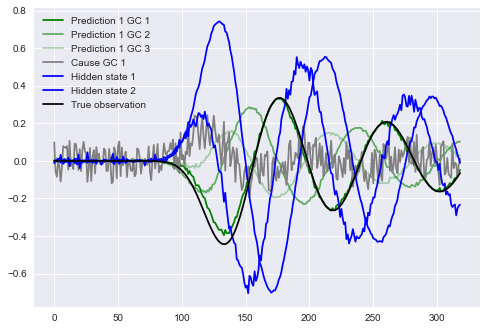

In [9]:
# Process the observation sequence in parallel instead of sequentially
# This time without providing a cause input

net = GPC_net(b_size=len(res1), dynamical_net=False, cause_sizes=[4, 1], hidden_sizes=[0, 2], gen_coords=3)

feed_cause = False; plot = False; generate = False;
inference_steps = 10; epochs = 1

c = true_cause_seq

for epoch in range(epochs):
    # logging
    errors, cov_h, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3 = [[] for _ in range(8)]
    err_g1, err_g2, err_g3, cov_g1, cov_g2, cov_g3 = [[] for _ in range(6)]
    err_h1, err_h2, err_h3, l0, l1, l2, l3, l4, l5, l6 = [[] for _ in range(10)]

    # initialize weights
    net.layers[1].net_h[0].weight = torch.nn.Parameter(C) #  hierarchical weights g(x)
    net.layers[1].dyn_model.nets_d[0].weight = torch.nn.Parameter(torch.cat([B.T,A]).T) # dynamical weights f(x)
    net.layers[1].dyn_model.nets_d[1].weight = torch.nn.Parameter(net.layers[1].dyn_model.nets_d[1].weight) # dynamical weights f(x)

    # prior prediction
    pred = net.layers[1].forward() # hierarchical prediction

    # infer
    for _ in range(inference_steps):
        # feed sensory observations in generalized coordinates
        net.layers[0].dyn_model.layers[0].states.cause_state = seq_batch1
        net.layers[0].dyn_model.layers[1].states.cause_state = seq_batch2
        net.layers[0].dyn_model.layers[2].states.cause_state = seq_batch3

        e, _, _, ch, _ = net.iterative_inference(data=None, target=c if feed_cause else None) # step hierarchical
        eg1, eh1, ed1, cg1, cd1 = net.layers[1].dyn_model.iterative_inference(predict_hierarchical=False) # step dynamical

    # posterior prediction
    pred = net.layers[1].forward() # hierarchical prediction

    # logging
    errors, cov_h = errors + e, cov_h + ch
    errors_d1, cov_d1 = errors_d1 + ed1, cov_d1 + cd1
    err_g1, cov_g1, err_h1 = err_g1 + eg1, cov_g1 + cg1, err_h1+eh1

if plot and not generate: # plot losses
    plot_graph(errors, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3,cov_g1,
       cov_g2, cov_g3, err_g1, err_g2, err_g3, err_h1, err_h2, err_h3, cov_h,
       hierarchical=True, g_coords=False, dynamical=True)

plt.plot(pred[0][:,0], color="green", label=f"Prediction 1 GC {1}")
plt.plot(pred[1][:,0], color="green", label=f"Prediction 1 GC {2}", alpha=0.6)
plt.plot(pred[2][:,0], color="green", label=f"Prediction 1 GC {3}", alpha=0.3)
plt.plot(net.layers[1].states.cause_state.detach().numpy().copy()[:,0], color="grey", label="Cause GC 1")
plt.plot(net.layers[1].states.hidd_state.detach().numpy().copy()[:,0], color="blue", label="Hidden state 1")
plt.plot(net.layers[1].states.hidd_state.detach().numpy().copy()[:,1], color="blue", label="Hidden state 2")
plt.plot(np.asarray(res1)[:,0,0], color="black", label="True observation")
plt.legend(); plt.show()

In [10]:
# todo
# - infer weights for A, B, C in the sequential and parallel case
# - compare correlated noise levels

/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


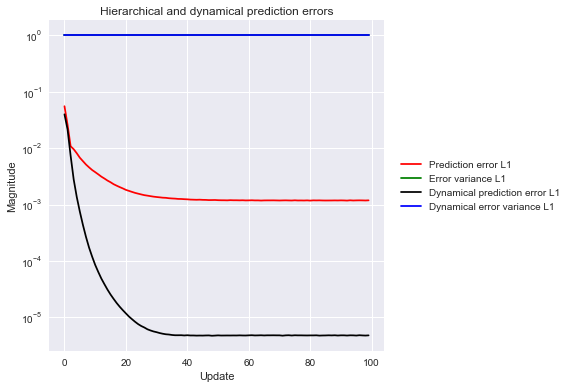

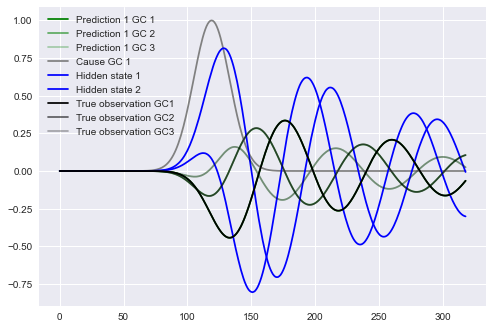

In [11]:
# Again: Sequence as batch, cause provided.
# Task: infer transition weights
from model_learn import * # same model with .001 weights learning rate

net = GPC_net(b_size=len(res1), dynamical_net=False, cause_sizes=[4, 1], hidden_sizes=[0, 2], gen_coords=3)

# turn cause sequence into a batch
true_cause_seq = torch.stack(true_cause,0).reshape([319,1])

# turn sensory observations from sequences into batches
seq_batch1 = torch.from_numpy(np.asarray(res1)).reshape([319,4])
seq_batch2 = torch.from_numpy(np.asarray(res2)).reshape([319,4])
seq_batch3 = torch.from_numpy(np.asarray(res3)).reshape([319,4])

feed_cause = True; plot = True; generate = False;
inference_steps = 10; epochs = 100

c = true_cause_seq

# logging
errors, cov_h, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3 = [[] for _ in range(8)]
err_g1, err_g2, err_g3, cov_g1, cov_g2, cov_g3 = [[] for _ in range(6)]
err_h1, err_h2, err_h3, l0, l1, l2, l3, l4, l5, l6 = [[] for _ in range(10)]

for epoch in range(epochs):

    # initialize weights
    net.layers[1].net_h[0].weight = torch.nn.Parameter(C) #  hierarchical weights g(x)
    #net.layers[1].dyn_model.nets_d[0].weight = torch.nn.Parameter(torch.cat([B.T,A]).T) # dynamical weights f(x)
    #net.layers[1].dyn_model.nets_d[1].weight = torch.nn.Parameter(net.layers[1].dyn_model.nets_d[1].weight) # dynamical weights f(x)

    # prior prediction
    #pred = net.layers[1].forward() # hierarchical prediction

    # infer
    for _ in range(inference_steps):
        # feed sensory observations in generalized coordinates
        net.layers[0].dyn_model.layers[0].states.cause_state = seq_batch1
        net.layers[0].dyn_model.layers[1].states.cause_state = seq_batch2
        net.layers[0].dyn_model.layers[2].states.cause_state = seq_batch3

        e, _, _, ch, _ = net.iterative_inference(data=None, target=c if feed_cause else None) # step hierarchical
        eg1, eh1, ed1, cg1, cd1 = net.layers[1].dyn_model.iterative_inference(predict_hierarchical=False) # step dynamical

    # posterior prediction
    pred = net.layers[1].forward() # hierarchical prediction

    # logging
    errors, cov_h = errors + e, cov_h + ch
    errors_d1, cov_d1 = errors_d1 + ed1, cov_d1 + cd1
    err_g1, cov_g1, err_h1 = err_g1 + eg1, cov_g1 + cg1, err_h1+eh1

if plot and not generate: # plot losses
    plot_graph(errors, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3,cov_g1,
       cov_g2, cov_g3, err_g1, err_g2, err_g3, err_h1, err_h2, err_h3, cov_h,
       hierarchical=True, g_coords=False, dynamical=True)

plt.plot(pred[0][:,0], color="green", label=f"Prediction 1 GC {1}")
plt.plot(pred[1][:,0], color="green", label=f"Prediction 1 GC {2}", alpha=0.6)
plt.plot(pred[2][:,0], color="green", label=f"Prediction 1 GC {3}", alpha=0.3)
plt.plot(net.layers[1].states.cause_state.detach().numpy().copy()[:,0], color="grey", label="Cause GC 1")
plt.plot(net.layers[1].states.hidd_state.detach().numpy().copy()[:,0], color="blue", label="Hidden state 1")
plt.plot(net.layers[1].states.hidd_state.detach().numpy().copy()[:,1], color="blue", label="Hidden state 2")
plt.plot(np.asarray(res1)[:,0,0], color="black", label="True observation GC1")
plt.plot(np.asarray(res2)[:,0,0], color="black", label="True observation GC2", alpha=0.6)
plt.plot(np.asarray(res3)[:,0,0], color="black", label="True observation GC3", alpha=0.3)
plt.legend(); plt.show()

In [15]:
print("Learned dynamical weights: ", list(net.layers[1].dyn_model.nets_d[0].weight[:,1:3].data))
print("A", list(A))

Learned dynamical weights:  [tensor([ 0.0611, -0.7652]), tensor([ 0.7508, -0.2102])]
A [tensor([0.0484, 0.7535]), tensor([-0.7617, -0.2187])]


In [16]:
print("Learned dynamical weights: ", list(net.layers[1].dyn_model.nets_d[0].weight[:,:1].data))
print("B", list(B))

Learned dynamical weights:  [tensor([0.3677]), tensor([0.3542])]
B [tensor([0.3604]), tensor([0.3604])]
